In [1]:
# SYSTEM LEVEL IMPORTS
import sys

# THIRD-PARTY IMPORTS
# For matrices and calculations
import numpy as np
# For machine learning (backend for keras)
import tensorflow as tf
#tf.compat.v1.disable_v2_behavior
# User-friendly machine learning library
# Front end for TensorFlow
import keras 
# Different methods from Keras needed to create an RNN
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Activation 
from keras.layers.recurrent import SimpleRNN, GRU
# For graphing
import matplotlib.pyplot as plt

# Changing the import directory
sys.path.append('../DataSets/')
# LOCAL IMPORTS
# Encoded data sets but can apply this code to any data set
#from Datasets import *
from EquationOfState import *

Using TensorFlow backend.


In [2]:
# Get a string that represents the name of the data set, a recommended training 
# dimension for the data, the total x data, and the total y data for a data set
# the is encoded in the file DataSets.py
# This code can be used with other data sets as long as a training dimension is supplied
# with the name "dim", the x data is in a one dimensional numpy array named "X_tot", and the
# y data is in a one dimensional numpy array called "y_tot".
X_tot, y_tot, design_matrix = EquationOfState()
dim = 80
# Check to see if the data set is complete
assert len(X_tot) == len(y_tot)

In [3]:
def format_data(data, length_of_sequence = 2):  
    """
        Inputs:
            data(a numpy array): the data that will be the inputs to the recurrent neural
                network
            length_of_sequence (an int): the number of elements in one iteration of the
                sequence patter.  For a function approximator use length_of_sequence = 2.
        Returns:
            rnn_input (a 3D numpy array): the input data for the recurrent neural network.  Its
                dimensions are length of data - length of sequence, length of sequence, 
                dimnsion of data
            rnn_output (a numpy array): the training data for the neural network
        Formats data to be used in a recurrent neural network.  The resulting data points have the
        following format for a sequence length of n: ((y1, y2, ..., yn), yn+1).  This function is 
        adapted from the one found here: 
        https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
    """
    # To store the formated "x" and "y" data
    X, Y = [], []
    for i in range(len(data)-length_of_sequence):
        # Get the next length_of_sequence elements
        a = data[i:i+length_of_sequence]
        # Get the element that immediately follows that
        b = data[i+length_of_sequence]
        # Reshape so that each data point is contained in its own array
        a = np.reshape (a, (len(a), 1))
        X.append(a)
        Y.append(b)
    # Convert into numpy arrays as these are easier to use later in the code.
    rnn_input = np.array(X)
    rnn_output = np.array(Y)
    return rnn_input, rnn_output



In [4]:
def rnn(length_of_sequences, hidden_neurons, loss, optimizer, activation_dense, activation_rnn, rate, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the length of sequence used to format the data set
            hidden_neurons (an int): the number of neurons to be used in the SimpleRNN layers, or double the number
                of neurons to be used in the Dense layers
            loss (a string): the loss function to be used
            optimizer (a string): the optimizer to be used
            activation (a string): the activation to be used in the dense layers
            rate (an int or float): the L2 regulization rate (not used in this example)
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): a compiled recurrent neural network consisting of one input layer followed by
                2 dense (feedforward layers), then three simple recurrent neural network layers, and finally an
                output layer.
        Builds and compiles a Keras recurrent neural network with specified parameters using two hidden dense 
        layers followed by three hidden simple recurrent neural network layers.
    """
    # Number of neurons in the input and output layers
    in_out_neurons = 1
    # Input layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons)) 
    # Hidden dense layers
    dnn = Dense(hidden_neurons/2, activation=activation_dense, name='dnn')(inp)
    dnn1 = Dense(hidden_neurons/2, activation=activation_dense, name='dnn1')(dnn)
    # Hidden simple recurrent layers
    rnn1 = GRU(hidden_neurons, 
                    return_sequences=True, activation = activation_rnn,
                    stateful = stateful,
                    name="RNN1", use_bias=True,recurrent_dropout=0.0, kernel_regularizer=keras.regularizers.l2(rate))(dnn1)
    rnn2 = GRU(hidden_neurons, 
                    return_sequences=True, activation = activation_rnn,
                    stateful = stateful,
                    name="RNN2", use_bias=True,recurrent_dropout=0.0, kernel_regularizer=keras.regularizers.l2(rate))(rnn1)
    rnn = GRU(hidden_neurons, 
                    return_sequences=False, activation = activation_rnn,
                    stateful = stateful,
                    name="RNN", use_bias=True,recurrent_dropout=0.0, kernel_regularizer=keras.regularizers.l2(rate))(rnn2)
    # Output layer
    dens = Dense(in_out_neurons,name="dense")(rnn)
    # Build the model
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the model
    model.compile(loss=loss, optimizer=optimizer)  
    # Return the model
    return model

In [11]:
# Generate the training data for the RNN using a sequence length of 2
# Get the first dim points from the total data set to use for training
X_train = X_tot[:dim]
y_train = y_tot[:dim]

X_train = X_train.reshape((-1, 1))
# Formating the y component of the training data using the time series forecasting 
rnn_input, rnn_training = format_data(y_train, 2)



In [12]:
## use the default values for batch_size, stateful
model = rnn(1, 250, 'mse', 'adam', 'relu', 'relu', 0.0, batch_size = None, stateful = False)
# Print a summary of the Keras model to the console
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
dnn (Dense)                  (None, 1, 125)            250       
_________________________________________________________________
dnn1 (Dense)                 (None, 1, 125)            15750     
_________________________________________________________________
RNN1 (GRU)                   (None, 1, 250)            282750    
_________________________________________________________________
RNN2 (GRU)                   (None, 1, 250)            376500    
_________________________________________________________________
RNN (GRU)                    (None, 250)               376500    
_________________________________________________________________
dense (Dense)                (None, 1)                

In [13]:
# Fit the model using the training data created above using 150 training iterations and a
# validation split of 0.05
hist = model.fit(X_train, y_train, batch_size=None, epochs=500, 
                 verbose=True,validation_split=0.1)

Epoch 1/500
3/3 [==============================] - 0s 158ms/step - loss: 285374.6250 - val_loss: 1698771.0000
Epoch 2/500
3/3 [==============================] - 0s 12ms/step - loss: 285346.6562 - val_loss: 1698594.7500
Epoch 3/500
3/3 [==============================] - 0s 11ms/step - loss: 285295.1250 - val_loss: 1698233.7500
Epoch 4/500
3/3 [==============================] - 0s 14ms/step - loss: 285206.7188 - val_loss: 1697517.3750
Epoch 5/500
3/3 [==============================] - 0s 14ms/step - loss: 285005.6250 - val_loss: 1696023.3750
Epoch 6/500
3/3 [==============================] - 0s 16ms/step - loss: 284638.7812 - val_loss: 1692717.0000
Epoch 7/500
3/3 [==============================] - 0s 14ms/step - loss: 283830.0000 - val_loss: 1685032.2500
Epoch 8/500
3/3 [==============================] - 0s 14ms/step - loss: 282218.0938 - val_loss: 1666430.2500
Epoch 9/500
3/3 [==============================] - 0s 13ms/step - loss: 278576.4688 - val_loss: 1624554.7500
Epoch 10/500
3/3 [

3/3 [==============================] - 0s 14ms/step - loss: 245.4752 - val_loss: 3316.3235
Epoch 79/500
3/3 [==============================] - 0s 16ms/step - loss: 240.5061 - val_loss: 3074.5308
Epoch 80/500
3/3 [==============================] - 0s 15ms/step - loss: 235.0336 - val_loss: 2994.1060
Epoch 81/500
3/3 [==============================] - 0s 16ms/step - loss: 230.6757 - val_loss: 3149.3521
Epoch 82/500
3/3 [==============================] - 0s 17ms/step - loss: 226.0617 - val_loss: 3232.9951
Epoch 83/500
3/3 [==============================] - 0s 13ms/step - loss: 221.8405 - val_loss: 3228.2266
Epoch 84/500
3/3 [==============================] - 0s 13ms/step - loss: 217.5653 - val_loss: 3116.8328
Epoch 85/500
3/3 [==============================] - 0s 12ms/step - loss: 212.7410 - val_loss: 3122.9417
Epoch 86/500
3/3 [==============================] - 0s 12ms/step - loss: 207.9378 - val_loss: 2969.7229
Epoch 87/500
3/3 [==============================] - 0s 14ms/step - loss: 204.

3/3 [==============================] - 0s 13ms/step - loss: 81.2028 - val_loss: 2162.8438
Epoch 157/500
3/3 [==============================] - 0s 13ms/step - loss: 75.0135 - val_loss: 2657.1042
Epoch 158/500
3/3 [==============================] - 0s 14ms/step - loss: 78.3822 - val_loss: 2442.7766
Epoch 159/500
3/3 [==============================] - 0s 14ms/step - loss: 75.3248 - val_loss: 2131.1919
Epoch 160/500
3/3 [==============================] - 0s 11ms/step - loss: 74.0816 - val_loss: 2189.6716
Epoch 161/500
3/3 [==============================] - 0s 11ms/step - loss: 74.0768 - val_loss: 2346.3442
Epoch 162/500
3/3 [==============================] - 0s 11ms/step - loss: 73.1484 - val_loss: 2084.0874
Epoch 163/500
3/3 [==============================] - 0s 12ms/step - loss: 72.0015 - val_loss: 2000.9417
Epoch 164/500
3/3 [==============================] - 0s 13ms/step - loss: 71.4276 - val_loss: 2217.2085
Epoch 165/500
3/3 [==============================] - 0s 11ms/step - loss: 70.5

Epoch 235/500
3/3 [==============================] - 0s 14ms/step - loss: 42.1693 - val_loss: 1622.4058
Epoch 236/500
3/3 [==============================] - 0s 13ms/step - loss: 42.2576 - val_loss: 1554.7556
Epoch 237/500
3/3 [==============================] - 0s 13ms/step - loss: 41.6937 - val_loss: 1545.3838
Epoch 238/500
3/3 [==============================] - ETA: 0s - loss: 40.29 - 0s 12ms/step - loss: 41.5120 - val_loss: 1534.5592
Epoch 239/500
3/3 [==============================] - 0s 13ms/step - loss: 40.9857 - val_loss: 1594.6417
Epoch 240/500
3/3 [==============================] - 0s 12ms/step - loss: 40.8363 - val_loss: 1458.1256
Epoch 241/500
3/3 [==============================] - 0s 11ms/step - loss: 40.6666 - val_loss: 1468.2853
Epoch 242/500
3/3 [==============================] - 0s 12ms/step - loss: 40.8787 - val_loss: 1380.6438
Epoch 243/500
3/3 [==============================] - 0s 14ms/step - loss: 39.8694 - val_loss: 1547.6726
Epoch 244/500
3/3 [=====================

3/3 [==============================] - 0s 14ms/step - loss: 24.7329 - val_loss: 1392.9182
Epoch 314/500
3/3 [==============================] - 0s 13ms/step - loss: 23.8786 - val_loss: 1159.2878
Epoch 315/500
3/3 [==============================] - 0s 14ms/step - loss: 23.2073 - val_loss: 1221.7754
Epoch 316/500
3/3 [==============================] - 0s 12ms/step - loss: 22.6760 - val_loss: 1311.7224
Epoch 317/500
3/3 [==============================] - 0s 12ms/step - loss: 22.8693 - val_loss: 1158.3784
Epoch 318/500
3/3 [==============================] - 0s 14ms/step - loss: 22.4833 - val_loss: 1100.8230
Epoch 319/500
3/3 [==============================] - 0s 13ms/step - loss: 22.6082 - val_loss: 1171.8398
Epoch 320/500
3/3 [==============================] - 0s 13ms/step - loss: 21.9607 - val_loss: 1308.2411
Epoch 321/500
3/3 [==============================] - 0s 15ms/step - loss: 22.3334 - val_loss: 1178.4900
Epoch 322/500
3/3 [==============================] - 0s 13ms/step - loss: 21.6

3/3 [==============================] - 0s 13ms/step - loss: 10.7470 - val_loss: 955.3499
Epoch 393/500
3/3 [==============================] - 0s 13ms/step - loss: 10.5332 - val_loss: 1065.3225
Epoch 394/500
3/3 [==============================] - 0s 13ms/step - loss: 10.1030 - val_loss: 922.7482
Epoch 395/500
3/3 [==============================] - 0s 13ms/step - loss: 9.9689 - val_loss: 909.7311
Epoch 396/500
3/3 [==============================] - 0s 14ms/step - loss: 9.7304 - val_loss: 985.5202
Epoch 397/500
3/3 [==============================] - 0s 13ms/step - loss: 9.2849 - val_loss: 959.2942
Epoch 398/500
3/3 [==============================] - 0s 13ms/step - loss: 9.1375 - val_loss: 996.9493
Epoch 399/500
3/3 [==============================] - 0s 14ms/step - loss: 9.3723 - val_loss: 993.9833
Epoch 400/500
3/3 [==============================] - 0s 16ms/step - loss: 8.8755 - val_loss: 803.6996
Epoch 401/500
3/3 [==============================] - 0s 13ms/step - loss: 10.7547 - val_loss

3/3 [==============================] - 0s 20ms/step - loss: 4.1107 - val_loss: 861.4823
Epoch 473/500
3/3 [==============================] - 0s 16ms/step - loss: 3.3914 - val_loss: 838.4366
Epoch 474/500
3/3 [==============================] - 0s 16ms/step - loss: 3.3159 - val_loss: 895.3379
Epoch 475/500
3/3 [==============================] - 0s 14ms/step - loss: 3.7450 - val_loss: 820.1382
Epoch 476/500
3/3 [==============================] - 0s 14ms/step - loss: 3.7301 - val_loss: 843.7783
Epoch 477/500
3/3 [==============================] - 0s 14ms/step - loss: 3.5247 - val_loss: 881.7654
Epoch 478/500
3/3 [==============================] - 0s 14ms/step - loss: 3.6674 - val_loss: 748.5276
Epoch 479/500
3/3 [==============================] - 0s 13ms/step - loss: 3.6481 - val_loss: 967.6965
Epoch 480/500
3/3 [==============================] - 0s 14ms/step - loss: 4.2586 - val_loss: 802.6691
Epoch 481/500
3/3 [==============================] - 0s 14ms/step - loss: 4.3032 - val_loss: 826

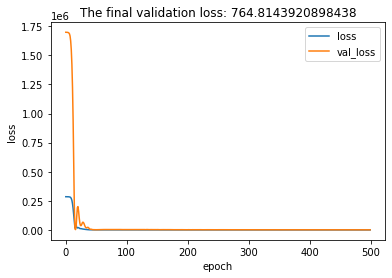

In [14]:
# Creates a graph of the training loss/error and the validation loss/error as a function of the
# number of training iterations performed.  This is useful to make sure the model is not 
# overtraining.
# Get the data from the trained model and plot it
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
# Label the x axis, the y axis, and add a title
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
# Add a legend then show the plot
plt.legend()
plt.show()

In [17]:
y_test = y_tot[dim:]
y_pred = model.predict(X_tot[dim:])

print(((y_test-y_pred)**2).mean())

312334.1270889614


In [15]:
def test_rnn (x_known, y_known):
    """
        Inputs: 
            x_known (a list or numpy array): the known x data, likely X_tot imported using
                the data set.
            y_known (a list or numpy array): the known y data, likely y_tot imported using
                the data set.
        Returns:
            None.
        Extrapolates from the training data to a complete data set using the trained recurrent
        neural network.  Performs data analysis on the predicted data points and creates a graph
        of the known data and the predicted data.
    """
    # Segment off the training data from the known data
    y_pred = y_known[:dim].tolist()
    # Create the first point that will be used to predict the following point using the trained
    # recurrent neural network.  In this case the first point contains the two points if the 
    # training data, so the first point that will be predicted is the first point to fall sequentially
    # after the training data
    next_input = np.array([[[y_known[dim-2]], [y_known[dim-1]]]])
    # Save the last number in the prediction point for later use
    last = [y_known[dim-1]]
    # Loop until the predicted data set is the same length as the known data set.
    for i in range (dim, len(y_known)):
        # Predict the next point and add it to the predicted data set
        next = model.predict(np.asarray(next_input))
        y_pred.append(next[0][0])
        # print the difference between the predicted point and the correspinding known point
        print ('DIFF: ', next[0][0]-y_known[i])
        # Create the point that will be uses to make a prediction on the next interation
        next_input = np.array([[last, next[0]]], dtype=np.float64)
        last = next
    # Print the MSE of the predicted data and the known data.  This is a measure of how well the 
    # extrapolation worked.
    print('MSE: ', np.square(np.subtract(y_known, y_pred)).mean())
    # Save the predicted data set as a csv file for future use
    #name = datatype + 'Predicted'+str(dim)+'.csv'
    #np.savetxt(name, y_pred, delimiter=',')
    # Plot both the known and the predicted data sets and add a legend
    fig, ax = plt.subplots()
    ax.plot(x_known, y_known, label="true", linewidth=3)
    ax.plot(x_known, y_pred, 'g-.',label="predicted", linewidth=4)
    ax.legend()
    # Create a semi-transparent red box to represent the training data
    ax.axvspan(x_known[0], x_known[dim], alpha=0.25, color='red')

DIFF:  1810970.8125816693
DIFF:  2188468276.437337
DIFF:  2642260523212.6704
DIFF:  3190146820208733.0
DIFF:  3.8516398096342036e+18
DIFF:  4.650296503932742e+21
DIFF:  5.614558247974168e+24
DIFF:  6.778765240021009e+27
DIFF:  8.184377023906616e+30
DIFF:  9.881449081322623e+33
MSE:  1.084923365898277e+66


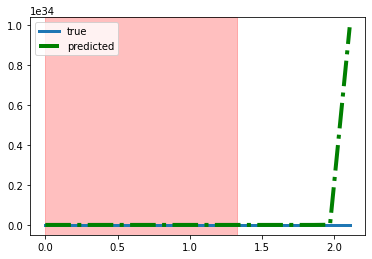

In [16]:
# Predict the remaining points to finish the data set
test_rnn(X_tot, y_tot)